In [1]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import src.utils as utils

from src.Data import Data
from src.Camera import Camera
from src.Plot import Plot
from src.VisualOdometry import VisualOdometry

import matplotlib.pyplot as plt

In [2]:
data = Data()
camera = Camera('data/camera.dat')

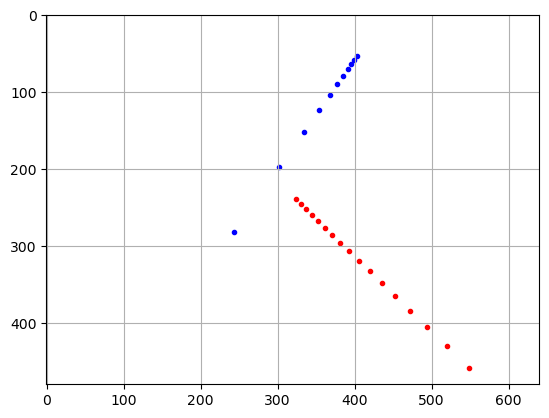

In [14]:
T = [[1, 0, 0, 0.5],
     [0, 1, 0, 50],
     [0, 0, 1, 1.2],
     [0, 0, 0, 1]]
T = np.array(T)

Rx = utils.Rx(np.pi/2)
Ry = utils.Ry(0)
Rz = utils.Rz(0)

T[:3,:3] = Rz @ Ry @ Rx


line1 = []
for i in range(1,101):
    x = i
    y = i + 20
    z = i
    line1.append([x, y, z])

line2 = []
for i in range(1,101):
    x = -i+10
    y = i*1.5 + 30
    z = i*2 - 20
    line2.append([x, y, z])


# plot the line1
fig = go.Figure()
x_coords = [point[0] for point in line1]
y_coords = [point[1] for point in line1]
z_coords = [point[2] for point in line1]
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2, color='red')))

# plot the line2
x_coords = [point[0] for point in line2]
y_coords = [point[1] for point in line2]
z_coords = [point[2] for point in line2]
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2, color='blue')))

# plot a vector that show the pose T
t = T[:3,3]
u = np.array([1, 0, 0])
rotated_u = T[:3,:3] @ u
rotated_u = rotated_u * 30
v = t + rotated_u
x_coords = [t[0], v[0]]
y_coords = [t[1], v[1]]
z_coords = [t[2], v[2]]
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='lines', marker=dict(size=10, color='green')))
fig.add_trace(go.Scatter3d(x=[t[0]], y=[t[1]], z=[t[2]], mode='markers', marker=dict(size=3, color='green')))

fig.show()


# project the points onto the image plane
projected_points_line1 = []
for i in range(100):
    point = line1[i]
    
    image_point_hom, image_point = camera.project_point(point, T)
    if image_point_hom is None or image_point is None:
        continue
    
    projected_points_line1.append(image_point)

projected_points_line2 = []
for i in range(100):
    point = line2[i]

    image_point_hom, image_point = camera.project_point(point, T)
    if image_point_hom is None or image_point is None:
        continue
    
    projected_points_line2.append(image_point)

fig, ax = plt.subplots()
ax.imshow(np.ones((480, 640, 3)))
ax.scatter([point[0] for point in projected_points_line1], [point[1] for point in projected_points_line1], color='red', marker='.')
ax.scatter([point[0] for point in projected_points_line2], [point[1] for point in projected_points_line2], color='blue', marker='.')

plt.grid()
plt.show()

Estimated w_T_c:
 [[ 1.  0.  0.  0.]
 [-0.  1.  0.  0.]
 [-0. -0.  1.  1.]
 [ 0.  0.  0.  1.]]


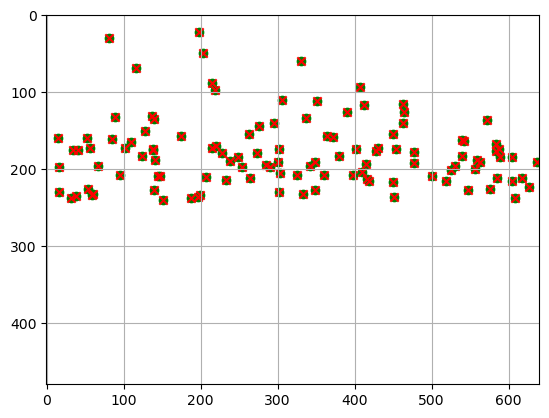

In [5]:
vo = VisualOdometry(camera, data)
vo.initialize()
index = 1

measurements = data.get_measurement_points(index)
matches = vo.data_association(measurements, vo.get_map())
image_points = matches['points_1']
world_points = matches['points_2']
appearances = matches['appearances']

w_T_c = vo.get_trajectory()['poses'][index]
print('Estimated w_T_c:\n', np.round(w_T_c, 2))

projected_points = []
for i in range(len(world_points)):
    proj_image_point_hom, proj_image_point = camera.project_point(world_points[i], w_T_c)

    if proj_image_point_hom is None or proj_image_point is None:
        continue    
    projected_points.append(proj_image_point)

fig, ax = plt.subplots()
ax.imshow(np.ones((480, 640, 3)))
ax.scatter([point[0] for point in image_points], [point[1] for point in image_points], color='green', marker='o')
ax.scatter([point[0] for point in projected_points], [point[1] for point in projected_points], color='red', marker='x')
plt.grid()
plt.show()

In [6]:
pose_0 = vo.get_trajectory()['poses'][0]
pose_1 = vo.get_trajectory()['poses'][1]

world_points = vo.get_map()['points']
print('Number of world points: ', len(world_points))

x_coords = [point[0] for point in world_points]
y_coords = [point[1] for point in world_points]
z_coords = [point[2] for point in world_points]

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2)))

fig.add_trace(go.Scatter3d(x=[pose_0[0, 3]], y=[pose_0[1, 3]], z=[pose_0[2, 3]], mode='markers', marker=dict(size=4, color='red')))
fig.add_trace(go.Scatter3d(x=[pose_1[0, 3]], y=[pose_1[1, 3]], z=[pose_1[2, 3]], mode='markers', marker=dict(size=4, color='blue')))
fig.add_trace(go.Scatter3d(x=[pose_0[0, 3], pose_1[0, 3]], y=[pose_0[1, 3], pose_1[1, 3]], z=[pose_0[2, 3], pose_1[2, 3],], mode='lines', line=dict(color='black', width=2)))

fig.show()

Number of world points:  115


In [7]:
map = vo.get_map()
points = map['points']

C = camera.get_camera_transform()
points_hom = np.hstack((points, np.ones((len(points), 1))))
points_hom = np.dot(C, points_hom.T).T
points = points_hom[:, :3]

appearances = map['appearances']
set_1 = {'points': points, 'appearances': appearances}

set_2 = {'points': [], 'appearances': []}
world = data.get_world()
for i in range(len(world)):
    landmark_position = world[i]['landmark_position']
    landmark_appearances = world[i]['landmark_appearance']
    set_2['points'].append(landmark_position)
    set_2['appearances'].append(landmark_appearances)

matches = vo.data_association(set_1, set_2)
map_points = matches['points_1']
world_points = matches['points_2']

x_coords = [point[0]*0.208 for point in map_points]
y_coords = [point[1]*0.208 for point in map_points]
z_coords = [point[2]*0.208 for point in map_points]

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2, color='blue')))

x_coords = [point[0] for point in world_points]
y_coords = [point[1] for point in world_points]
z_coords = [point[2] for point in world_points]

fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2, color='red')))
fig.show()

In [8]:
for i in range(2,121):
    print('Processing frame: ', i)
    vo.one_step(i)

Processing frame:  2
T_0:
 [[ 1.  0.  0.  0.]
 [-0.  1.  0.  0.]
 [-0. -0.  1.  1.]
 [ 0.  0.  0.  1.]]
T_0_1:
 [[ 1.   -0.   -0.   -0.  ]
 [-0.    1.   -0.    0.  ]
 [-0.   -0.    1.   -1.04]
 [ 0.    0.    0.    1.  ]]
T_1:
 [[ 1.    0.    0.    0.  ]
 [-0.    1.    0.    0.  ]
 [-0.   -0.    1.    2.04]
 [ 0.    0.    0.    1.  ]]
-----------------------------------------------


Processing frame:  3
T_0:
 [[ 1.    0.    0.    0.  ]
 [-0.    1.    0.    0.  ]
 [-0.   -0.    1.    2.04]
 [ 0.    0.    0.    1.  ]]
T_0_1:
 [[ 1.   -0.    0.   -0.  ]
 [-0.    1.   -0.    0.  ]
 [ 0.   -0.    1.   -1.73]
 [ 0.    0.    0.    1.  ]]
T_1:
 [[ 1.    0.    0.    0.  ]
 [-0.    1.    0.    0.  ]
 [-0.   -0.    1.    3.77]
 [ 0.    0.    0.    1.  ]]
-----------------------------------------------


Processing frame:  4
T_0:
 [[ 1.    0.    0.    0.  ]
 [-0.    1.    0.    0.  ]
 [-0.   -0.    1.    3.77]
 [ 0.    0.    0.    1.  ]]
T_0_1:
 [[ 1.   -0.    0.   -0.  ]
 [-0.    1.   -0.    0.  

In [9]:
estimated_trajectory = vo.get_trajectory()
gt_trajectory = data.get_trajectory()

C = camera.get_camera_transform()
C_inv = np.linalg.inv(C)    

estimated_poses = estimated_trajectory['poses']
estimated_poses_in_world = [] 

MAX_FRAMES = 121
for i in range(len(estimated_poses)):
    if i == MAX_FRAMES: break
    pose = estimated_poses[i]
    pose_in_world = pose @ C_inv
    estimated_poses_in_world.append(pose_in_world)
    

estimated_positions = []
estimated_positions_in_world = [] 
for i in range(len(estimated_poses_in_world)):
    estimated_positions.append(estimated_poses[i][:3, 3]*0.208)
    estimated_positions_in_world.append(estimated_poses_in_world[i][:3, 3]*0.208)

gt_poses = []
gt_positions = []
for i in range(121):
    if i == MAX_FRAMES: break
    x_gt, y_gt, theta_gt = gt_trajectory[i]['ground_truth_pose']
    gt_poses.append(np.array([x_gt, y_gt, 0, 0, 0, theta_gt]))
    gt_positions.append(np.array([x_gt, y_gt, 0]))
    
fig = go.Figure()
gt_x_coords = [position[0] for position in gt_positions]
gt_y_coords = [position[1] for position in gt_positions]
gt_z_coords = [position[2] for position in gt_positions]
fig.add_trace(go.Scatter3d(x=gt_x_coords, y=gt_y_coords, z=gt_z_coords, mode='lines', name='GT trajectory', line=dict(color='green')))

estimated_x_coords = [position[0] for position in estimated_positions]
estimated_y_coords = [position[1] for position in estimated_positions]
estimated_z_coords = [position[2] for position in estimated_positions]
fig.add_trace(go.Scatter3d(x=estimated_x_coords, y=estimated_y_coords, z=estimated_z_coords, mode='lines', name='Estimated trajectory', line=dict(color='red')))

estimated_x_coords_in_world = [position[0] for position in estimated_positions_in_world]
estimated_y_coords_in_world = [position[1] for position in estimated_positions_in_world]
estimated_z_coords_in_world = [position[2] for position in estimated_positions_in_world]
fig.add_trace(go.Scatter3d(x=estimated_x_coords_in_world, y=estimated_y_coords_in_world, z=estimated_z_coords_in_world, mode='lines', name='Estimated trajectory in world frame', line=dict(color='blue')))

fig.show()

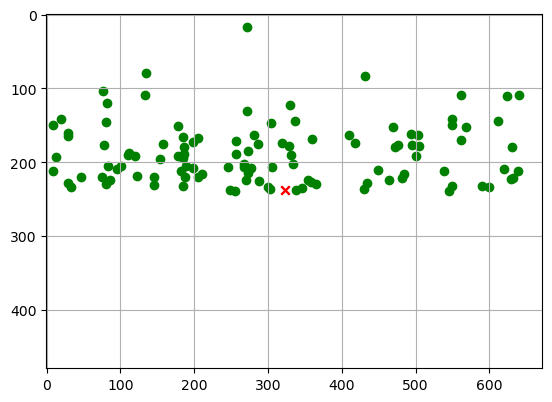

In [10]:
index = 100

measurements = data.get_measurement_points(index)
matches = vo.data_association(measurements, vo.get_map())
image_points = matches['points_1']
world_points = matches['points_2']
appearances = matches['appearances']

estimated_w_T_c = vo.get_trajectory()['poses'][index]

projected_points = []
for i in range(len(world_points)):
    proj_image_point_hom, proj_image_point = camera.project_point(world_points[i], estimated_w_T_c)
    if proj_image_point_hom is None or proj_image_point is None:
        continue
    projected_points.append(proj_image_point)

fig, ax = plt.subplots()
ax.imshow(np.ones((480, 640, 3)))
ax.scatter([point[0] for point in image_points], [point[1] for point in image_points], color='green', marker='o')
ax.scatter([point[0] for point in projected_points], [point[1] for point in projected_points], color='red', marker='x')
plt.grid()
plt.show()

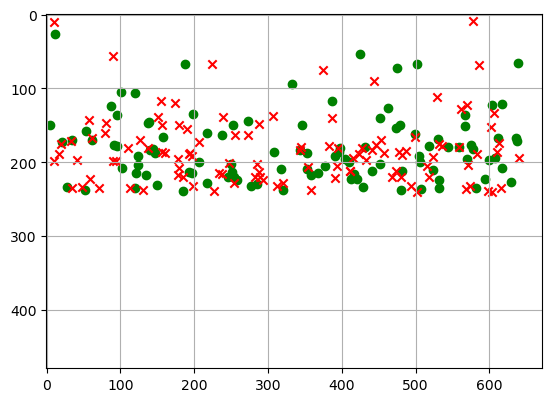

In [11]:
index = 17

prev_measurements = data.get_measurement_points(index-1)
measurements = data.get_measurement_points(index)

prev_image_points = []
for i in range(len(prev_measurements['points'])):
    prev_image_points.append(prev_measurements['points'][i])

image_points = []
for i in range(len(measurements['points'])):
    image_points.append(measurements['points'][i])

fig, ax = plt.subplots()
ax.imshow(np.ones((480, 640, 3)))
ax.scatter([point[0] for point in prev_image_points], [point[1] for point in prev_image_points], color='green', marker='o')
ax.scatter([point[0] for point in image_points], [point[1] for point in image_points], color='red', marker='x')
plt.grid()
plt.show()

In [12]:
index = 34

pose = vo.get_trajectory()['poses'][index]
map = vo.get_trajectory()['world_points'][index]
points = map['points']
C = camera.get_camera_transform()
points_hom = np.hstack((points, np.ones((len(points), 1))))
points_hom = np.dot(C, points_hom.T).T
points = points_hom[:, :3]
appearances = map['appearances']
set_1 = {'points': points, 'appearances': appearances}
set_2 = {'points': [], 'appearances': []}
world = data.get_world()
for i in range(len(world)):
    landmark_position = world[i]['landmark_position']
    landmark_appearances = world[i]['landmark_appearance']
    set_2['points'].append(landmark_position)
    set_2['appearances'].append(landmark_appearances)
matches = vo.data_association(set_1, set_2)
map_points = matches['points_1']
world_points = matches['points_2']
fig = go.Figure()
x_coords = [point[0]*0.208 for point in map_points]
y_coords = [point[1]*0.208 for point in map_points]
z_coords = [point[2]*0.208 for point in map_points]
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2, color='blue')))
x_coords = [point[0] for point in world_points]
y_coords = [point[1] for point in world_points]
z_coords = [point[2] for point in world_points]
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2, color='red')))
fig.show()

In [13]:
fig = go.Figure()
world_points = vo.get_map()['points']

world_points_hom = np.hstack((world_points, np.ones((len(world_points), 1))))
C = camera.get_camera_transform()
world_points = (C @ world_points_hom.T).T
print('Number of world points: ', len(world_points))

x_coords = [point[0]*0.208 for point in world_points]
y_coords = [point[1]*0.208 for point in world_points]
z_coords = [point[2]*0.208 for point in world_points]

fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=1)))


points = []
world_points = data.get_world()
for i in range(len(world_points)):
    landmark_position = world_points[i]['landmark_position']   
    points.append(landmark_position)

x_coords = [point[0] for point in points]
y_coords = [point[1] for point in points]
z_coords = [point[2] for point in points]

fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=1, color='red')))



fig.show()

Number of world points:  490
